# Práctica 2 - Ejercicio 1

Asignatura: Programación para la Inteligencia Artificial

Alumno: Jesús García Gaitán

Este es el primer ejercicio de la Práctica 2 de Programación para la Inteligencia Artificial. Este ejercicio se debe entregar en un cuaderno de Jupyter separado del segundo.

El objetivo de este ejercicio es entrenar un modelo neuronal de clasificación usando solo neuronas lineales para el conjunto de datos CIFAR10. El conjunto está incluido en torchvision:

https://docs.pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html

Dado el tamaño del conjunto de datos y los tiempos que puede tardar el entrenamiento, se requiere que el código permita elegir dispositivo de ejecución ('cpu' o 'cuda'). En el caso de elegir la opción de ejecución en GPU (y de haber una GPU disponible), el código deberá realizar el entrenamiento en GPU de manera eficiente.

Se espera el uso de las herramientas pertinentes tanto para completar el código como para realizar experimentos de los que se puedan extraer conclusiones sobre la capacidad del modelo entrenado. En el cuaderno se deben incluir los experimentos más relevantes.

Como conjunto de test se debe usar el conjunto de test íntegro que provee el conjunto de datos.

Se debe incluir una comparación de tiempos de entrenamiento en CPU y GPU.

El cuaderno entregado debe llamarse ApellidosNombrePractica2Ejercicio1.ipynb

Consejos:
*  Cambiar el optimizador SGD por Adam. Lo veremos en clase próximamente :)
*  Normalizar los colores de las imágenes al rango [0,1].


In [1]:
import torch
import torch.nn as nn
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import time
from torch.utils.data import TensorDataset

In [6]:
def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, (_, _) in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, (_, _) in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset

class Early_Stop():
  def __init__(self, patience=5, delta=0):
    self.patience = patience
    self.delta = delta
    self.best_val_loss = None
    self.no_val_improvement_times = 0
    self.stop = False

  def check_stop(self, val_loss):
    if self.best_val_loss is None or (val_loss + self.delta) < self.best_val_loss:
      self.best_val_loss = val_loss
      self.no_val_improvement_times = 0
    else:
      self.no_val_improvement_times += 1
      self.stop = self.no_val_improvement_times >= self.patience

class XYDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.numel()

    def __getitem__(self, idx):
        return self.x[idx].float(), self.y[idx].float()
    

# Loop de entrenamiento con validación

def learning_loop_for_classification_with_early_stopping(train_dataloader, val_dataloader, model, epochs, loss_fn, learning_rate, optimizer, validation_freq, early_stop, device):
  epoch_loss_list = []
  val_loss_list = []
  val_acc_list = []

  opt = optimizer(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-4
    )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      steps_loss_list = []
      for x_true, y_true in train_dataloader:
        x_true, y_true = x_true.to(device), y_true.to(device)
        y_pred = model(x_true)                              # Forward
        opt.zero_grad()
        loss = loss_fn(y_pred, y_true)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()
      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      if epoch%validation_freq==0:
        val_step_loss_list = []
        val_correct_answers = 0
        val_set_size = 0 
        with torch.no_grad():
          for x_val_true, y_val_true in val_dataloader:
            x_val_true, y_val_true = x_val_true.to(device), y_val_true.to(device)
            y_val_pred = model(x_val_true)

            loss_val = loss_fn(y_val_pred, y_val_true)
            val_step_loss_list.append(loss_val)

            correct_answers = torch.sum(y_val_true==torch.argmax(y_val_pred, dim=-1))
            val_correct_answers += correct_answers
            val_set_size += y_val_true.numel()

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)
          val_acc_list.append(val_correct_answers/float(val_set_size))

        early_stop.check_stop(val_loss)
        if early_stop.stop:
          print("Early Stop.")
          break

  return model, epoch_loss_list, val_loss_list, val_acc_list

In [3]:
workpath = 'C:/Users/jegag/Desktop/Phyton/Practicas IA/AI_model-training/data'
print("Cargando datasets...")
train_dataset = torchvision.datasets.CIFAR10(root=workpath, train=True, download=True, transform=transforms.ToTensor())
test_dataset = torchvision.datasets.CIFAR10(root=workpath, train=False, download=True, transform=transforms.ToTensor())

train_dataset, val_dataset = split_dataset(train_dataset, split_share=0.8)
print("Datasets cargados")


print(f'Tamaño del conjunto de entrenamiento: {len(train_dataset)}')
print(f'Tamaño del conjunto de validación: {len(val_dataset)}')
print(f'Tamaño del conjunto de test: {len(test_dataset)}')

Cargando datasets...


100%|██████████| 170M/170M [00:36<00:00, 4.69MB/s] 


Datasets cargados
Tamaño del conjunto de entrenamiento: 39904
Tamaño del conjunto de validación: 10096
Tamaño del conjunto de test: 10000


In [4]:
print(f"Disponibilidad de CUDA: {torch.cuda.is_available()}")
print(f"Versión de CUDA: {torch.version.cuda if torch.cuda.is_available() else None}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando dispositivo: {device}')


batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3*32*32, 128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128, 128),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(128, 10),
)


model.to(device)

epochs = 50
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam
learning_rate = 1e-3
patience = 5
delta = 0.01
early_stop = Early_Stop(patience = patience,
                        delta = delta)

    
# Entrenamiento en CPU/GPU

model, train_losses, val_losses, val_accs = learning_loop_for_classification_with_early_stopping(train_loader, val_loader, model, epochs, loss_fn, learning_rate, optimizer=optimizer, validation_freq=1, early_stop=early_stop, device=device)


model.eval()
test_losses = []
with torch.no_grad():
    for x_test_batch, y_test_batch in test_loader:
        x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)  
        y_pred_batch = model(x_test_batch)
        loss = loss_fn(y_pred_batch, y_test_batch)
        test_losses.append(loss.item())

# Calculamos el error medio absoluto final en el conjunto de test
mean_test_error = sum(test_losses) / len(test_losses)
print(f"Error absoluto medio final en el conjunto de test: {mean_test_error:.4f}")



Disponibilidad de CUDA: False
Versión de CUDA: None
Usando dispositivo: cpu


epoch::  36%|███▌      | 18/50 [05:54<10:29, 19.68s/it, loss=1.2465033531188965]

Early Stop.


Error absoluto medio final en el conjunto de test: 1.4468


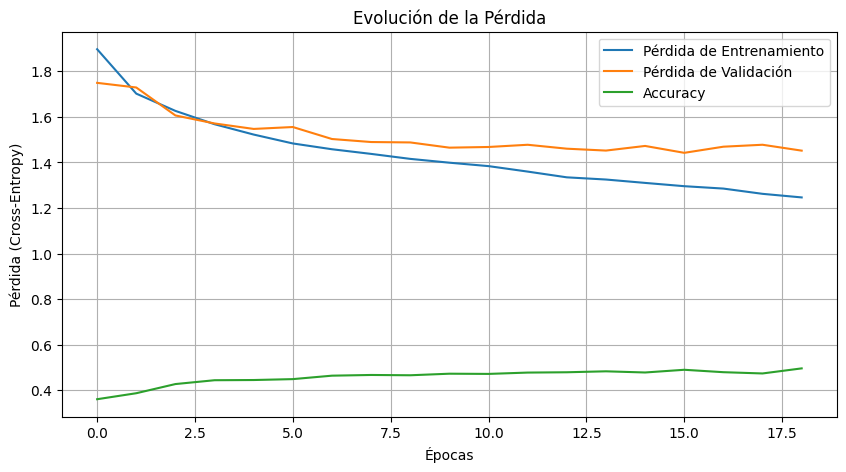

In [8]:
# Mueve los resultados a la CPU justo antes de graficar
if device == 'cuda':
    train_losses = [t.cpu().item() for t in train_losses]
    val_losses = [t.cpu().item() for t in val_losses]
    val_accs = [t.cpu().item() for t in val_accs]

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Pérdida de Entrenamiento')
plt.plot(val_losses, label='Pérdida de Validación')
plt.plot(val_accs, label='Accuracy')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (Cross-Entropy)')
plt.legend()
plt.grid(True)
plt.show()